In [66]:
%pip install contractions matplotlib numpy


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [67]:
import contractions
import string
import re
from collections import defaultdict

# Additional function to manually handle certain contractions not expanded by the library
def manual_contractions_fix(text):
    # Replace 've, 'm, and others that are missed
    text = text.replace("'ve", " have")
    text = text.replace("'m", " am")
    text = text.replace("'ll", " will")
    text = text.replace("'d", " would")
    text = text.replace("'re", " are")
    
    return text

def preprocess(text):
    expanded_text = contractions.fix(text)
    expanded_text = manual_contractions_fix(expanded_text)
    
    text_no_numbers = re.sub(r'\d+', '', expanded_text)
    
    translator = str.maketrans('', '', string.punctuation.replace('.', ''))  # Remove punctuation except periods
    cleaned_text = text_no_numbers.translate(translator)
    
    cleaned_text = cleaned_text.lower().strip()
    
    return cleaned_text.split()

def load_data(file_path):
    with open(file_path, 'r') as f:
        return [preprocess(line.strip()) for line in f]

def compute_ngram_counts(reviews):
    unigram_counts = defaultdict(int)
    bigram_counts = defaultdict(lambda: defaultdict(int))
    total_word_count = 0

    for review in reviews:
        total_word_count += len(review)
        
        for word in review:
            unigram_counts[word] += 1

        for i in range(1, len(review)):
            prev_word = review[i - 1]
            curr_word = review[i]
            bigram_counts[prev_word][curr_word] += 1

    return unigram_counts, bigram_counts, total_word_count

# Convert counts to probabilities (unsmoothed unigram and bigram)
def compute_ngram_probabilities(unigram_counts, bigram_counts, total_word_count):
    unigram_probabilities = {word: count / total_word_count for word, count in unigram_counts.items()}
    bigram_probabilities = {word: {next_word: count / unigram_counts[word] for next_word, count in next_words.items()} for word, next_words in bigram_counts.items()}
    
    return unigram_probabilities, bigram_probabilities

train_file_path = 'C:/Users/sxs230164/OneDrive - The University of Texas at Dallas/UTD FALL24/NLP/ass1/A1_DATASET/A1_DATASET/train.txt'
train_reviews = load_data(train_file_path)

unigram_counts, bigram_counts, total_word_count = compute_ngram_counts(train_reviews)

unigram_probabilities, bigram_probabilities = compute_ngram_probabilities(unigram_counts, bigram_counts, total_word_count)

print("Unigram Probabilities Sample:", dict(list(unigram_probabilities.items())[:5]))
print("Bigram Probabilities Sample:", {word: next_words for word, next_words in list(bigram_probabilities.items())[:5]})


Unigram Probabilities Sample: {'i': 0.020486264754774747, 'booked': 0.0010284989894399465, 'two': 0.0015307891935850365, 'rooms': 0.002415776696126386, 'four': 0.00023918581149766195}
Bigram Probabilities Sample: {'i': {'booked': 0.012259194395796848, 'was': 0.10799766491535318, 'had': 0.0642148277875073, 'am': 0.04786923525977817, 'spoke': 0.0011675423234092236, 'loved': 0.009340338587273789, 'love': 0.004086398131932283, 'really': 0.005837711617046118, 'have': 0.07764156450671336, 'preferred': 0.0005837711617046118, 'would': 0.08056042031523643, 'can': 0.01284296555750146, 'asked': 0.010507880910683012, 'think': 0.015178050204319907, 'came': 0.002335084646818447, 'noticed': 0.005253940455341506, 'were': 0.0035026269702276708, 'immediately': 0.0011675423234092236, 'called': 0.018680677174547577, 'went': 0.0070052539404553416, 'couple': 0.0005837711617046118, 'took': 0.004670169293636894, 'checked': 0.008172796263864565, 'showed': 0.0005837711617046118, 'did': 0.02626970227670753, 'rec

In [68]:
import math
from collections import defaultdict

def load_data(file_path):
    with open(file_path, 'r') as f:
        reviews = [line.strip().split() for line in f]
    return reviews

def compute_ngram_counts(reviews):
    unigram_counts = defaultdict(int)
    bigram_counts = defaultdict(lambda: defaultdict(int))
    
    total_word_count = 0
    for review in reviews:
        total_word_count += len(review)
        for i, word in enumerate(review):
            unigram_counts[word] += 1
            if i > 0:
                bigram_counts[review[i - 1]][word] += 1
                
    return unigram_counts, bigram_counts, total_word_count

def filter_vocabulary(unigram_counts, min_freq=3):
    filtered_vocab = {word for word, count in unigram_counts.items() if count >= min_freq}
    return filtered_vocab

def handle_unknown_words(reviews, filtered_vocab, unknown_token="<UNK>"):
    processed_reviews = []
    for review in reviews:
        processed_review = [word if word in filtered_vocab else unknown_token for word in review]
        processed_reviews.append(processed_review)
    return processed_reviews

def laplace_smoothing(unigram_counts, bigram_counts, vocab_size, alpha=1):
    smoothed_bigram_probs = defaultdict(lambda: defaultdict(float))
    for prev_word in bigram_counts:
        for curr_word in bigram_counts[prev_word]:
            smoothed_bigram_probs[prev_word][curr_word] = (
                (bigram_counts[prev_word][curr_word] + alpha) /
                (unigram_counts[prev_word] + alpha * vocab_size)
            )
    return smoothed_bigram_probs

def add_k_smoothing(unigram_counts, bigram_counts, vocab_size, k=0.01):
    smoothed_bigram_probs = defaultdict(dict)
    vocab = unigram_counts.keys()

    for w1 in unigram_counts:
        for w2 in vocab:
            bigram_count = bigram_counts[w1].get(w2, 0)
            smoothed_bigram_probs[w1][w2] = (bigram_count + k) / (unigram_counts[w1] + k * vocab_size)
    
    return smoothed_bigram_probs

# Interpolation function (bigram + unigram combination)
def interpolate_smoothing(unigram_counts, bigram_counts, vocab_size, lambda1=0.8, lambda2=0.2, alpha=0.01):
    smoothed_bigram_probs = defaultdict(lambda: defaultdict(float))
    total_unigram_count = sum(unigram_counts.values())
    
    for prev_word in bigram_counts:
        for curr_word in bigram_counts[prev_word]:
            bigram_prob = (bigram_counts[prev_word][curr_word] + alpha) / (unigram_counts[prev_word] + alpha * vocab_size)
            unigram_prob = (unigram_counts[curr_word] + alpha) / (total_unigram_count + alpha * vocab_size)
            smoothed_bigram_probs[prev_word][curr_word] = lambda1 * bigram_prob + lambda2 * unigram_prob
            
    return smoothed_bigram_probs

# Calculate perplexity using interpolated smoothing
def calculate_perplexity_interpolated(validation_reviews, smoothed_bigram_probs, unigram_counts, vocab_size, unknown_token="<UNK>"):
    N = sum(len(review) for review in validation_reviews)
    log_prob_sum = 0
    
    for review in validation_reviews:
        for i in range(1, len(review)):
            prev_word = review[i - 1]
            curr_word = review[i]
            if curr_word not in unigram_counts:
                curr_word = unknown_token
            if prev_word not in unigram_counts:
                prev_word = unknown_token
                
            prob = smoothed_bigram_probs[prev_word].get(curr_word, 1 / (unigram_counts[prev_word] + vocab_size))
            log_prob_sum += math.log(prob)
            
    perplexity = 2 ** (-log_prob_sum / N)
    return perplexity

def main():
    # Load training and validation datasets
    train_file_path = 'C:/Users/sxs230164/OneDrive - The University of Texas at Dallas/UTD FALL24/NLP/ass1/A1_DATASET/A1_DATASET/train.txt'  # Replace with actual path
    validation_file_path = 'C:/Users/sxs230164/OneDrive - The University of Texas at Dallas/UTD FALL24/NLP/ass1/A1_DATASET/A1_DATASET/val.txt'  # Replace with actual path
    
    train_reviews = load_data(train_file_path)
    validation_reviews = load_data(validation_file_path)
    unigram_counts, bigram_counts, total_word_count = compute_ngram_counts(train_reviews)
    filtered_vocab = filter_vocabulary(unigram_counts, min_freq=3)
    processed_train_reviews = handle_unknown_words(train_reviews, filtered_vocab)
    processed_validation_reviews = handle_unknown_words(validation_reviews, filtered_vocab)
    unigram_counts, bigram_counts, _ = compute_ngram_counts(processed_train_reviews)
    vocab_size = len(filtered_vocab)
    laplace_smoothed_probs = laplace_smoothing(unigram_counts, bigram_counts, vocab_size, alpha=1)
    add_k_smoothed_probs = add_k_smoothing(unigram_counts, bigram_counts, vocab_size, k=0.01)

    interpolated_smoothed_probs = interpolate_smoothing(unigram_counts, bigram_counts, vocab_size)
    
    # Calculate and print interpolated perplexity on the validation set
    perplexity = calculate_perplexity_interpolated(processed_validation_reviews, interpolated_smoothed_probs, unigram_counts, vocab_size)
    

    print("Sample Laplace Smoothed Bigram Probabilities:", {word: dict(next_words) for word, next_words in list(laplace_smoothed_probs.items())[:5]})
    print("Sample Add-k Smoothed Bigram Probabilities:", {word: dict(next_words) for word, next_words in list(add_k_smoothed_probs.items())[:5]})
    print(f"Total word count: {total_word_count}")
    print(f"Best Perplexity that is Interpolated Perplexity on validation set: {perplexity}")

if __name__ == "__main__":
    main()


Sample Laplace Smoothed Bigram Probabilities: {'I': {'booked': 0.005140758873929009, 'was': 0.04504283965728274, 'had': 0.026438188494492042, 'am': 0.01003671970624235, 'spoke': 0.0007343941248470012, 'LOVED': 0.0009791921664626683, 'love': 0.0017135862913096695, 'really': 0.0026927784577723377, "'ve": 0.010526315789473684, "'m": 0.008078335373317013, 'preferred': 0.0004895960832313342, "'d": 0.006364749082007344, 'can': 0.005630354957160343, 'would': 0.026193390452876376, 'asked': 0.004651162790697674, 'think': 0.006364749082007344, 'came': 0.0012239902080783353, 'noticed': 0.0024479804161566705, 'were': 0.0014687882496940024, 'immediately': 0.0007343941248470012, 'called': 0.007833537331701347, 'took': 0.002203182374541004, 'checked': 0.0036719706242350062, 'showed': 0.0004895960832313342, 'did': 0.01077111383108935, 'recently': 0.0017135862913096695, 'stay': 0.0019583843329253367, 'got': 0.006609547123623011, 'stayed': 0.01346389228886169, "'ll": 0.002937576499388005, 'mentioned': 0

Perplexities saved to unigram_perplexities.txt
Perplexities saved to bigram_perplexities.txt


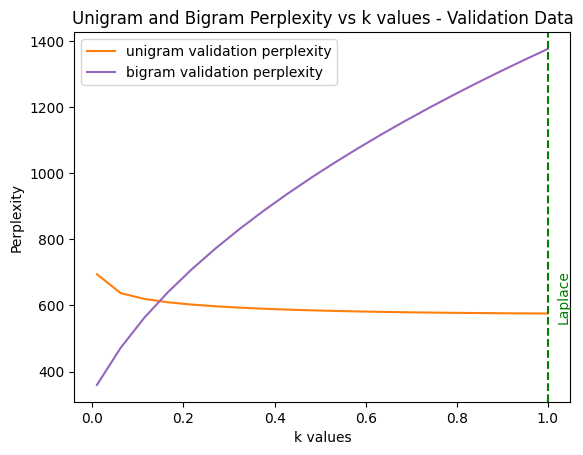

In [69]:
import math
import numpy as np
import matplotlib.pyplot as plt


def compute_perplexity(model, test_data, ngram_type='bigram', k=1.0, vocab_size=1):
    """
    Computes perplexity of a given n-gram model with add-k smoothing on the test data.
    The test_data is a list of tokenized reviews.
    """
    log_prob = 0
    total_tokens = 0
    
    for sentence in test_data:
        tokens = ['<s>'] + sentence + ['</s>']
        total_tokens += len(tokens) - 1 
        
        for i in range(1, len(tokens)):
            prev_word = tokens[i - 1]
            curr_word = tokens[i]

            if ngram_type == 'unigram':
                count_unigram = model['unigram'].get(curr_word, 0)
                prob = (count_unigram + k) / (sum(model['unigram'].values()) + k * vocab_size)
            else:  
                count_prev_word = model['unigram'].get(prev_word, 0)
                count_bigram = model['bigram'].get(prev_word, {}).get(curr_word, 0)
                prob = (count_bigram + k) / (count_prev_word + k * vocab_size)
            
            log_prob += math.log(prob)
    
    return math.exp(-log_prob / total_tokens)

def calculate_perplexities(train_data, validation_data, model, k_values, vocab_size, ngram_type):
    train_perplexities = []
    valid_perplexities = []
    
    for k in k_values:
        train_perplexity = compute_perplexity(model, train_data, ngram_type=ngram_type, k=k, vocab_size=vocab_size)
        train_perplexities.append(train_perplexity)
        
        valid_perplexity = compute_perplexity(model, validation_data, ngram_type=ngram_type, k=k, vocab_size=vocab_size)
        valid_perplexities.append(valid_perplexity)
    
    return train_perplexities, valid_perplexities

def plot_perplexities(k_values, unigram_perplexities_train, bigram_perplexities_train, unigram_perplexities_dev, bigram_perplexities_dev, token_count):
    plt.clf()
    plt.plot(k_values, unigram_perplexities_train, label='unigram train perplexity', color='blue')
    plt.plot(k_values, bigram_perplexities_train, label='bigram train perplexity', color='red')
    plt.axvline(x=1, color='green', linestyle='--', label="")
    plt.text(1.02, unigram_perplexities_train[-1], 'Laplace', rotation=90, color='green')
    plt.legend()
    plt.xlabel('k values')
    plt.ylabel('Perplexity')
    plt.title('Unigram and Bigram Perplexity vs k values - Train Data')
    plt.savefig(f"./uniandbigrams-plots/traindiagram_{token_count}.png")
    
    plt.clf()
    plt.plot(k_values, unigram_perplexities_dev, label='unigram validation perplexity', color='#ff7f0e')
    plt.plot(k_values, bigram_perplexities_dev, label='bigram validation perplexity', color='#9467bd')
    plt.legend()
    plt.xlabel('k values')
    plt.ylabel('Perplexity')
    plt.title('Unigram and Bigram Perplexity vs k values - Validation Data')
    plt.axvline(x=1, color='green', linestyle='--', label="")
    plt.text(1.02, unigram_perplexities_train[-1], 'Laplace', rotation=90, color='green')
    plt.savefig(f"./uniandbigrams-plots/testdiagram_{token_count}.png")

def save_perplexities_to_file(k_values, train_perplexities, validation_perplexities, filename='perplexities.txt'):
    with open(filename, 'w') as file:
        for i, k in enumerate(k_values):
            file.write(f"k = {k}\n")
            file.write(f"Perplexity on train data: {train_perplexities[i]:.2f}\n")
            file.write(f"Perplexity on validation data: {validation_perplexities[i]:.2f}\n")
            file.write("\n")
    print(f"Perplexities saved to {filename}")

def main():
    # Load and preprocess data
    train_file_path = 'C:/Users/sxs230164/OneDrive - The University of Texas at Dallas/UTD FALL24/NLP/ass1/A1_DATASET/A1_DATASET/train.txt'
    validation_file_path = 'C:/Users/sxs230164/OneDrive - The University of Texas at Dallas/UTD FALL24/NLP/ass1/A1_DATASET/A1_DATASET/val.txt'
    
    train_reviews = load_data(train_file_path)
    validation_reviews = load_data(validation_file_path)
    unigram_counts, bigram_counts, _ = compute_ngram_counts(train_reviews)
    ngram_model = {'unigram': unigram_counts, 'bigram': bigram_counts}
    vocab_size = len(unigram_counts)
    k_values = np.linspace(0.01, 1, 20)
    unigram_perplexities_train, unigram_perplexities_dev = calculate_perplexities(train_reviews, validation_reviews, ngram_model, k_values, vocab_size, 'unigram')
    bigram_perplexities_train, bigram_perplexities_dev = calculate_perplexities(train_reviews, validation_reviews, ngram_model, k_values, vocab_size, 'bigram')
    token_count = len(unigram_counts)
    plot_perplexities(k_values, unigram_perplexities_train, bigram_perplexities_train, unigram_perplexities_dev, bigram_perplexities_dev, token_count)
    save_perplexities_to_file(k_values, unigram_perplexities_train, unigram_perplexities_dev, filename='unigram_perplexities.txt')
    save_perplexities_to_file(k_values, bigram_perplexities_train, bigram_perplexities_dev, filename='bigram_perplexities.txt')

if __name__ == "__main__":
    main()
